In [42]:
import glob

In [43]:
from astroquery.svo_fps import SvoFps

In [44]:
jfilts = SvoFps.get_filter_list('JWST')
jfilts.add_index('filterID')

In [45]:
import numpy as np

In [46]:
from dust_extinction.averages import RRP89_MWGC, CT06_MWGC, F11_MWGC
from astropy import units as u

In [47]:
ext = CT06_MWGC()
ext(2.12*u.um) * 30, ext(4.8*u.um) * 30

(3.4232313962264147, 1.454796)

In [48]:
f480s = {geom: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/{geom}/convolved/JWST/NIRCam.F480M.fits')
         for geom in geoms}

In [49]:
f212s = {geom: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/{geom}/convolved/JWST/NIRCam.F212N.fits')
         for geom in geoms}

In [50]:
v1 = Table.read('/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.1/s---s-i/convolved/I1.fits')
v2 = Table.read('/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/s---s-i/convolved/Spitzer/IRAC.I1.fits')

In [51]:
geoms = [x.split("/")[-2] for x in glob.glob('/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/*/')
         if x.split("/")[-2].startswith('s')]
geoms

['s---s-i',
 's-pbsmi',
 's-p-hmi',
 'spu-hmi',
 'spubsmi',
 's-pbhmi',
 's-u-smi',
 's-ubhmi',
 'spu-smi',
 's-u-hmi',
 's-ubsmi',
 'sp--hmi',
 'sp--s-i',
 'spubhmi',
 's---smi',
 'sp--smi',
 's-p-smi',
 'sp--h-i']

In [52]:
from astropy.table import Table

In [53]:
path='/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/spubsmi/convolved/JWST/'
f770 = Table.read(f'{path}/MIRI.F770W.fits')
f470 =  Table.read(f'{path}/NIRCam.F470N.fits')

In [54]:
augpars_dict = {geom: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/{geom}_augmented.fits')
                for geom in geoms}
for key in augpars_dict:
    augpars_dict[key].add_index("MODEL_NAME")

In [55]:
augpars_dict['s---s-i'][:5]

<Table length=5>
 MODEL_NAME star.radius star.temperature scattering inclination   Model Luminosity 
                                                                       solLum      
  bytes20     float64       float64        int64      float64         float64      
----------- ----------- ---------------- ---------- ----------- -------------------
01QyhoBc_01      0.2728           4888.0          1        45.0 0.03827429493798022
01Xx6elC_01       0.383          12050.0          1        45.0  2.7863740310410456
03ZZRVTe_01       31.22           4967.0          1        45.0   534.4857312835463
03amqKIp_01       13.81           7891.0          1        45.0   666.2070265981496
03dloFhH_01       44.63           6450.0          1        45.0  3105.8917167595805

# Theo's classification downselection

 * MS: 0 (below) / 1 (on/above) / -1 (too cold)
 * Stage: 0 (0) / 1 (I) / 2 (II) / 3 (III) / -1 (none)
 * Class: 0 (0) / 1 (I) / 2 (Flat) / 3 (II) / 4 (III) / -1 (none)

In [56]:
classification_dict = {geom: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/real_models/{geom}.fits')
                       for geom in geoms}
for key in classification_dict:
    classification_dict[key].add_index("Model Name")

In [57]:
f470s = {geom: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/{geom}/convolved/JWST/NIRCam.F470N.fits')
         for geom in geoms}

In [58]:
f470s['sp--h-i'][:5]

<Table length=5>
 MODEL_NAME                TOTAL_FLUX                             TOTAL_FLUX_ERR             
                              mJy                                      mJy                   
  bytes30                 float64[20]                              float64[20]               
----------- ---------------------------------------- ----------------------------------------
016nTMSL_01 10.932071685791016 .. 10.932223320007324  10.926067352294922 .. 10.92621898651123
016nTMSL_02  10.94102954864502 .. 10.941184997558594 10.935020446777344 .. 10.935175895690918
016nTMSL_03 10.976465225219727 .. 10.976628303527832 10.970436096191406 .. 10.970599174499512
016nTMSL_04 11.043643951416016 .. 11.043824195861816 11.037578582763672 .. 11.037758827209473
016nTMSL_05 11.080031394958496 .. 11.080085754394531 11.073945999145508 .. 11.074000358581543

In [59]:
import pylab as pl
import numpy as np
from astropy import units as u

/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/function/logarithmic.py:67: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))


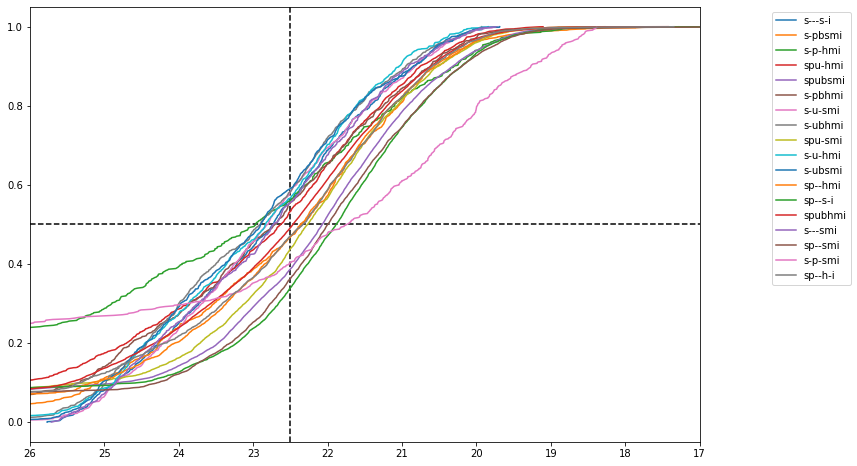

In [60]:
pl.figure(figsize=(12,8))
for geom in geoms:
    pars = augpars_dict[geom]
    f470 = f470s[geom]
    lum = pars['Model Luminosity']
    lumsel = (lum > 0.05) & (lum < 0.5)
    if any(lumsel):
        #pl.hist(f470['TOTAL_FLUX'][lumsel, 5], bins=np.geomspace(0.01, 10), label=geom)
        rslt = f470['TOTAL_FLUX'][lumsel, 5]
        rslt = rslt[np.isfinite(rslt)]
        rslt = np.sort(rslt)
        pl.plot((rslt / (8.5**2)).to(u.ABmag), np.arange(len(rslt)) / len(rslt), label=geom)
pl.legend(loc='upper left', bbox_to_anchor=(1.1,1))
pl.xlim(1e-5,5)
pl.axvline(22.5, linestyle='--', color='k', zorder=-50)
pl.axhline(0.5, linestyle='--', color='k', zorder=-50)
pl.xlim(26, 17);
#pl.semilogx();

/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


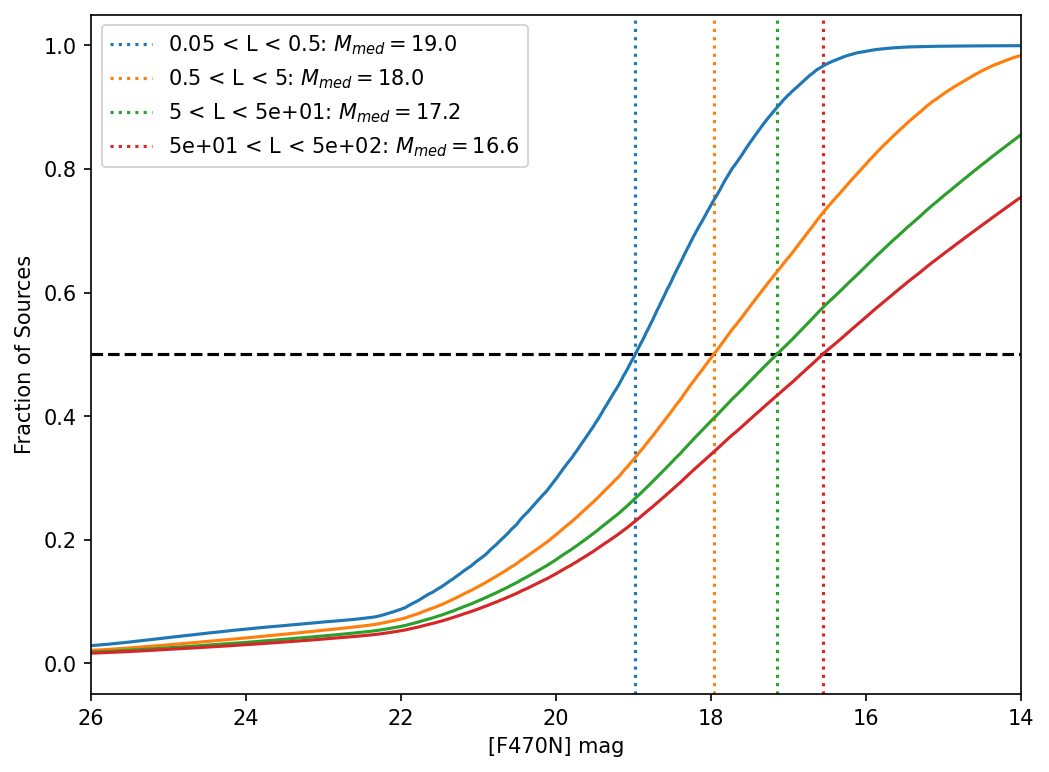

In [61]:
pl.figure(figsize=(8,6), dpi=150)
data = []
for lumlo, lumhi in ([(0.05, 0.5), (0.5, 5), (5, 50), (50, 500)]):
    for geom in geoms:
        pars = augpars_dict[geom]
        f470 = f470s[geom]
        lum = pars['Model Luminosity']
        lumsel = (lum > lumlo) & (lum <= lumhi)
        if any(lumsel):
            #pl.hist(f470['TOTAL_FLUX'][lumsel, 5], bins=np.geomspace(0.01, 10), label=geom)
            rslt = f470['TOTAL_FLUX'][lumsel, 5]
            rslt = rslt[np.isfinite(rslt)]
            rslt = np.sort(rslt)
            data = np.hstack([data, rslt])
            #pl.plot(rslt / (8.5**2), np.arange(len(rslt)) / len(rslt), label=geom)
    data = np.sort(data)
    magdata = -2.5*np.log10((u.Quantity(data, u.mJy).to(u.Jy) / (8.5**2)) / u.Quantity(jfilts.loc['JWST/NIRCam.F470N']['ZeroPoint'], u.Jy))
    L, = pl.plot(magdata.value, np.arange(len(data)) / len(data))
    #print(np.median(magdata))
    medmag = np.median(magdata).value
    #print(medmag)
    pl.axvline(medmag, linestyle=':', zorder=-100, color=L.get_color(), label=f'{lumlo:0.1g} < L < {lumhi:0.1g}: $M_{{med}}={medmag:0.1f}$')
    #pl.axvline(22.5, linestyle='--', color='k', zorder=-50)
pl.legend(loc='best')# bbox_to_anchor=(1.1,1))
pl.axhline(0.5, linestyle='--', color='k', zorder=-50)
pl.xlabel("[F470N] mag")
pl.ylabel("Fraction of Sources")
pl.xlim(26, 14);

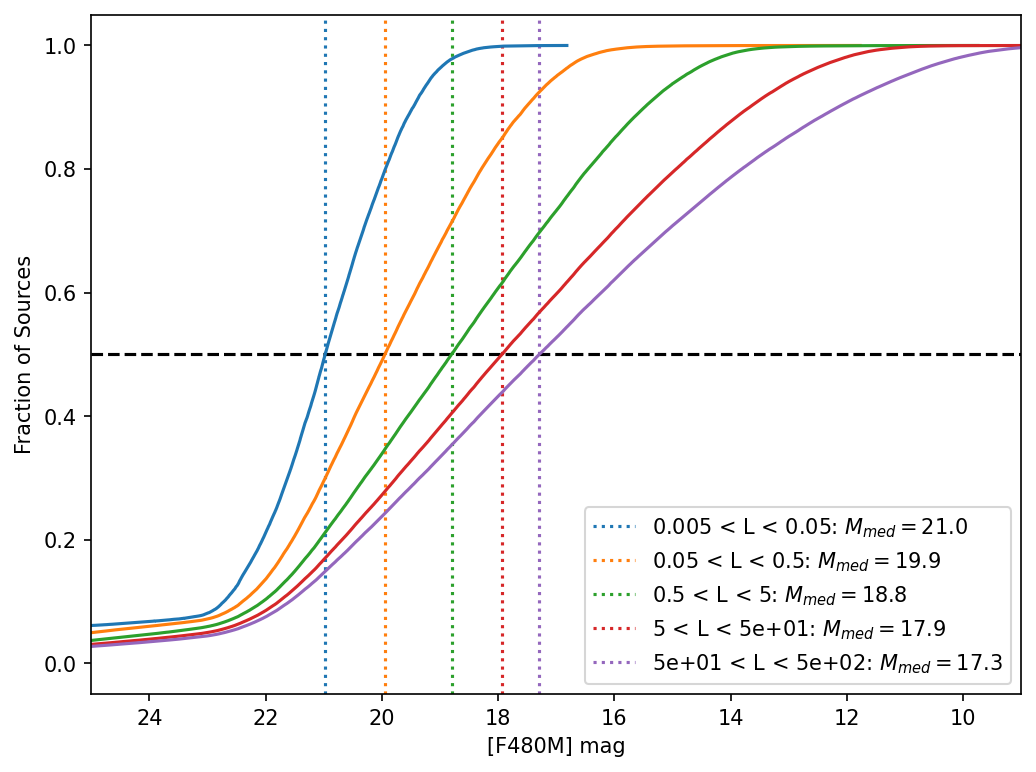

In [62]:
pl.figure(figsize=(8,6), dpi=150)
data = []
for lumlo, lumhi in ([(0.005, 0.05), (0.05, 0.5), (0.5, 5), (5, 50), (50, 500)]):
    for geom in geoms:
        pars = augpars_dict[geom]
        f480 = f480s[geom]
        lum = pars['Model Luminosity']
        lumsel = (lum > lumlo) & (lum <= lumhi)
        if any(lumsel):
            #pl.hist(f480['TOTAL_FLUX'][lumsel, 5], bins=np.geomspace(0.01, 10), label=geom)
            rslt = f480['TOTAL_FLUX'][lumsel, 5]
            rslt = rslt[np.isfinite(rslt)]
            rslt = np.sort(rslt)
            data = np.hstack([data, rslt])
            #pl.plot(rslt / (8.5**2), np.arange(len(rslt)) / len(rslt), label=geom)
    data = np.sort(data)
    magdata = -2.5*np.log10((u.Quantity(data, u.mJy).to(u.Jy) / (8.5**2)) / u.Quantity(jfilts.loc['JWST/NIRCam.F480M']['ZeroPoint'], u.Jy))
    L, = pl.plot(magdata.value, np.arange(len(data)) / len(data))
    #print(np.median(magdata))
    medmag = np.median(magdata).value
    #print(medmag)
    pl.axvline(medmag, linestyle=':', zorder=-100, color=L.get_color(), label=f'{lumlo:0.1g} < L < {lumhi:0.1g}: $M_{{med}}={medmag:0.1f}$')
    #pl.axvline(22.5, linestyle='--', color='k', zorder=-50)
pl.legend(loc='best')# bbox_to_anchor=(1.1,1))
pl.axhline(0.5, linestyle='--', color='k', zorder=-50)
pl.xlabel("[F480M] mag")
pl.ylabel("Fraction of Sources")
pl.xlim(25, 9);

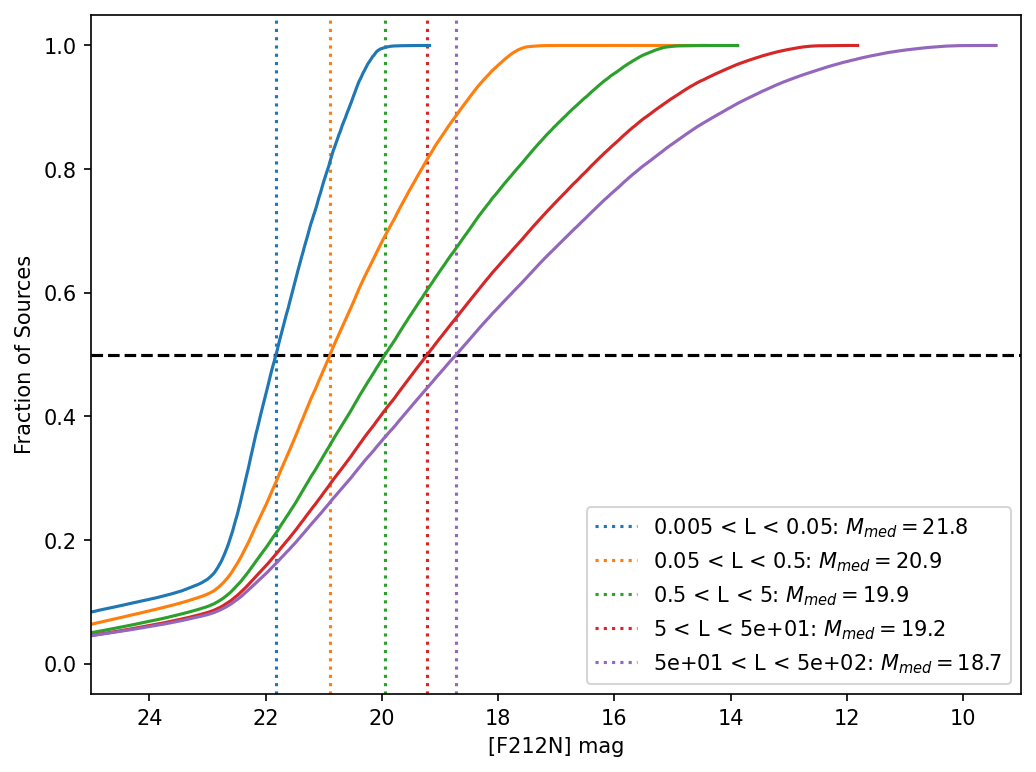

In [63]:
pl.figure(figsize=(8,6), dpi=150)
data = []
for lumlo, lumhi in ([(0.005, 0.05), (0.05, 0.5), (0.5, 5), (5, 50), (50, 500)]):
    for geom in geoms:
        pars = augpars_dict[geom]
        f212 = f212s[geom]
        lum = pars['Model Luminosity']
        lumsel = (lum > lumlo) & (lum <= lumhi)
        if any(lumsel):
            #pl.hist(f212['TOTAL_FLUX'][lumsel, 5], bins=np.geomspace(0.01, 10), label=geom)
            rslt = f212['TOTAL_FLUX'][lumsel, 5]
            rslt = rslt[np.isfinite(rslt)]
            rslt = np.sort(rslt)
            data = np.hstack([data, rslt])
            #pl.plot(rslt / (8.5**2), np.arange(len(rslt)) / len(rslt), label=geom)
    data = np.sort(data)
    magdata = -2.5*np.log10((u.Quantity(data, u.mJy).to(u.Jy) / (8.5**2)) / u.Quantity(jfilts.loc['JWST/NIRCam.F212N']['ZeroPoint'], u.Jy))
    L, = pl.plot(magdata.value, np.arange(len(data)) / len(data))
    #print(np.median(magdata))
    medmag = np.median(magdata).value
    #print(medmag)
    pl.axvline(medmag, linestyle=':', zorder=-100, color=L.get_color(), label=f'{lumlo:0.1g} < L < {lumhi:0.1g}: $M_{{med}}={medmag:0.1f}$')
    #pl.axvline(22.5, linestyle='--', color='k', zorder=-50)
pl.legend(loc='best')# bbox_to_anchor=(1.1,1))
pl.axhline(0.5, linestyle='--', color='k', zorder=-50)
pl.xlabel("[F212N] mag")
pl.ylabel("Fraction of Sources")
pl.xlim(25, 9);

In [64]:
v1[:5]

<Table length=5>
 MODEL_NAME                 TOTAL_FLUX                                TOTAL_FLUX_ERR               
                               mJy                                         mJy                     
  bytes30                  float64[20]                                 float64[20]                 
----------- ------------------------------------------ --------------------------------------------
01QyhoBc_01 0.08572807163000107 .. 0.08572807163000107 0.045907262712717056 .. 0.045907262712717056
01Xx6elC_01 0.40042707324028015 .. 0.40042707324028015   0.21437837183475494 .. 0.21437837183475494
03ZZRVTe_01   1145.8604736328125 .. 1145.8604736328125       613.5994262695312 .. 613.5994262695312
03amqKIp_01       360.282958984375 .. 360.282958984375     192.92376708984375 .. 192.92376708984375
03dloFhH_01       3054.14208984375 .. 3054.14208984375     1635.4383544921875 .. 1635.4383544921875

In [65]:
v2[:5]

<Table length=5>
 MODEL_NAME                 TOTAL_FLUX                               TOTAL_FLUX_ERR              
                               mJy                                        mJy                    
  bytes30                  float64[20]                                float64[20]                
----------- ------------------------------------------ ------------------------------------------
01QyhoBc_01 0.08614949136972427 .. 0.08614949136972427 0.04607214406132698 .. 0.04607214406132698
01Xx6elC_01 0.40248963236808777 .. 0.40248963236808777 0.21522556245326996 .. 0.21522556245326996
03ZZRVTe_01   1151.5093994140625 .. 1151.5093994140625     615.8174438476562 .. 615.8174438476562
03amqKIp_01     362.0877685546875 .. 362.0877685546875   193.64117431640625 .. 193.64117431640625
03dloFhH_01     3069.375244140625 .. 3069.375244140625   1641.4869384765625 .. 1641.4869384765625

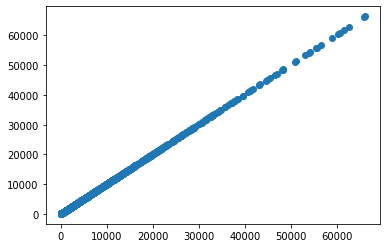

In [66]:
pl.scatter(v1['TOTAL_FLUX'][:,5], v2['TOTAL_FLUX'][:,5])

(array([ 388., 1094., 1266., 1303., 1262., 1287., 1275., 1284.,  678.,
         163.]),
 array([ 2.50224402,  4.41791501,  6.33358601,  8.24925701, 10.164928  ,
        12.080599  , 13.99627   , 15.91194099, 17.82761199, 19.74328299,
        21.65895398]),
 <BarContainer object of 10 artists>)

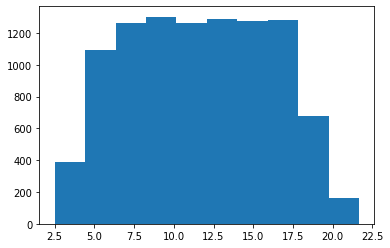

In [67]:
pl.hist(-2.5*np.log10(v2['TOTAL_FLUX'][:,5]/666000))

In [68]:
%matplotlib inline
import pylab as pl

In [69]:
from astropy.table import Table
from astropy.visualization import simple_norm

In [70]:
basepath = '/orange/adamginsburg/jwst/brick/'

In [71]:
mist = Table.read(f'{basepath}/isochrones/MIST_iso_633a08f2d8bb1.iso.cmd',
                  header_start=12, data_start=13, format='ascii', delimiter=' ', comment='#')
mist['410M405'] = mist['F410M']
mist['405M410'] = mist['F405N']

In [72]:
distance_modulus = 5*np.log10(8500)-5
distance_modulus

14.647094628571466

In [73]:
from astropy.visualization import simple_norm

In [ ]:
f212s['s---s-i'][:5]

In [ ]:
pl.figure(dpi=150)

norm = simple_norm(mist['initial_mass'][mist['log10_isochrone_age_yr'] < 7], stretch='log')
for age in np.unique(mist['log10_isochrone_age_yr']):
    if age in (5,6,7):
    
        agesel = mist['log10_isochrone_age_yr'] == age
        pl.scatter(mist['F210M'][agesel] - mist['F480M'][agesel],
                   (mist['F210M'])[agesel]+distance_modulus,
                   c=mist['initial_mass'][agesel],
                   norm=norm,
                   cmap='inferno',
                   alpha=0.5,
                   s=1,
                  )

        
cb = pl.colorbar()
cb.set_ticks([0.5,1,5,10,50,250])
cb.set_label("Mass")

mag212 = (u.Quantity(f212s['s---s-i']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2).to(u.ABmag)
mag480 = (u.Quantity(f480s['s---s-i']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2).to(u.ABmag)
#pl.scatter(mag212-mag480, mag212, s=1, zorder=-10)

#pl.axhline(0, linestyle='--', color='k')
#pl.axvline(0, linestyle='--', color='k')
pl.xlabel("[F210M]-[F480M]")
pl.ylabel("[F210M]")
#pl.axis([-0.2,0.1,-0.1,0.3])
pl.ylim(25,3)
pl.xlim([-0.25, 0.5]);
#agesel.sum()

In [76]:
distance_modulus

14.647094628571466

In [77]:
#mag212b = -2.5*np.log10(tables[2.12*u.um]['TOTAL_FLUX'][sel, 0] / jfilts.loc['JWST/NIRCam.F212N']['ZeroPoint'])
#mag480b = -2.5*np.log10(tables[4.80*u.um]['TOTAL_FLUX'][sel, 0] / jfilts.loc['JWST/NIRCam.F480M']['ZeroPoint'])
mag212 = -2.5*np.log10((u.Quantity(f212s['s---s-i']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2) / u.Quantity(jfilts.loc['JWST/NIRCam.F212N']['ZeroPoint'], u.Jy))
mag480 = -2.5*np.log10((u.Quantity(f480s['s---s-i']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2) / u.Quantity(jfilts.loc['JWST/NIRCam.F480M']['ZeroPoint'], u.Jy))

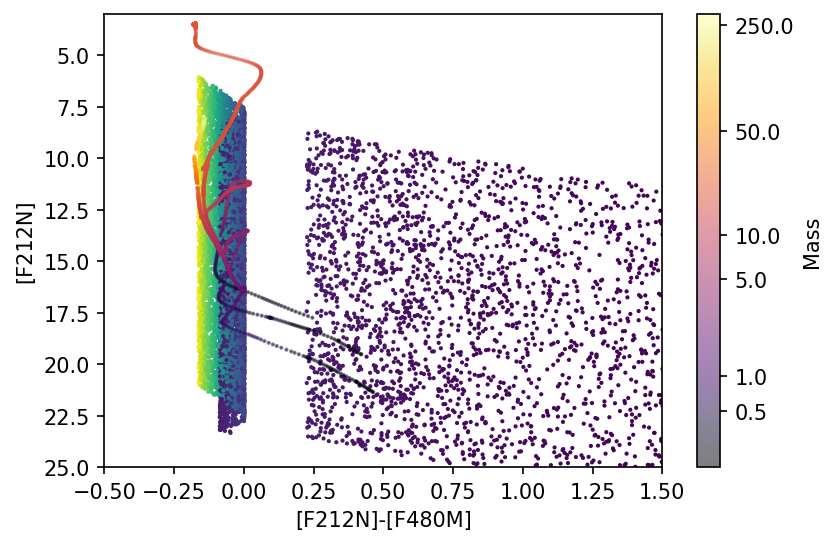

In [78]:
pl.figure(dpi=150)

norm = simple_norm(mist['initial_mass'][mist['log10_isochrone_age_yr'] < 7], stretch='log')
for age in np.unique(mist['log10_isochrone_age_yr']):
    if age in (5,6,7):
    
        agesel = mist['log10_isochrone_age_yr'] == age
        pl.scatter(mist['F212N'][agesel] - mist['F480M'][agesel],
                   (mist['F212N'])[agesel]+distance_modulus,
                   c=mist['initial_mass'][agesel],
                   norm=norm,
                   cmap='inferno',
                   alpha=0.5,
                   s=1,
                  )

        
cb = pl.colorbar()
cb.set_ticks([0.5,1,5,10,50,250])
cb.set_label("Mass")

#mag212 = (u.Quantity(f212s['s---s-i']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2).to(u.ABmag)
#mag480 = (u.Quantity(f480s['s---s-i']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2).to(u.ABmag)
geom = 's---s-i'
mag212 = -2.5*np.log10((u.Quantity(f212s[geom]['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2) / u.Quantity(jfilts.loc['JWST/NIRCam.F212N']['ZeroPoint'], u.Jy))
mag480 = -2.5*np.log10((u.Quantity(f480s[geom]['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2) / u.Quantity(jfilts.loc['JWST/NIRCam.F480M']['ZeroPoint'], u.Jy))
pl.scatter(mag212-mag480, mag212, s=1, c=augpars_dict[geom]['star.temperature'], zorder=-10)

#pl.axhline(0, linestyle='--', color='k')
#pl.axvline(0, linestyle='--', color='k')
pl.xlabel("[F212N]-[F480M]")
pl.ylabel("[F212N]")
#pl.axis([-0.2,0.1,-0.1,0.3])
pl.ylim(25,3)
pl.xlim([-0.5, 1.5]);
#agesel.sum()

/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/scratch/local/12219594/ipykernel_3371307/3746835578.py:34: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb2.draw_all()


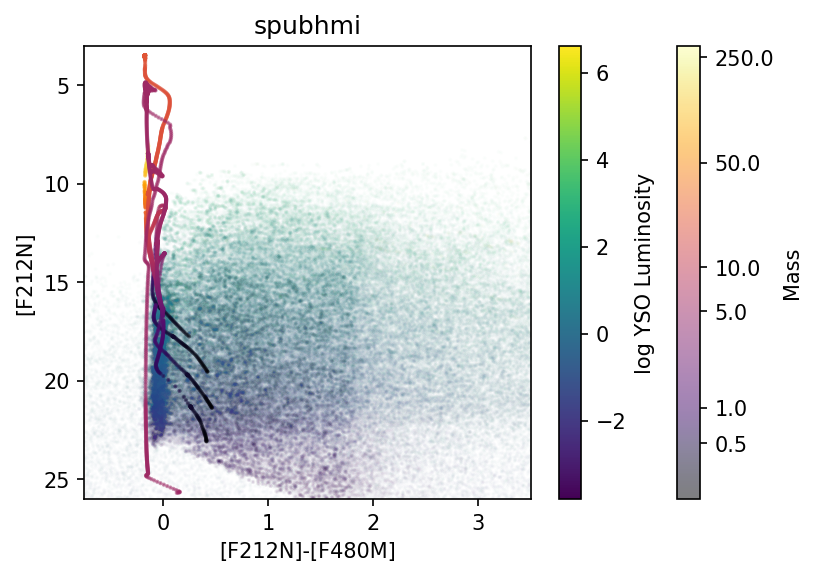

In [79]:
pl.figure(dpi=150)

norm = simple_norm(mist['initial_mass'][mist['log10_isochrone_age_yr'] < 7], stretch='log')
for age in np.unique(mist['log10_isochrone_age_yr']):
    if age in (5,6,7,8):
    
        agesel = mist['log10_isochrone_age_yr'] == age
        pl.scatter(mist['F212N'][agesel] - mist['F480M'][agesel],
                   (mist['F212N'])[agesel]+distance_modulus,
                   c=mist['initial_mass'][agesel],
                   norm=norm,
                   cmap='inferno',
                   alpha=0.5,
                   s=1,
                  )

        
cb = pl.colorbar()
cb.set_ticks([0.5,1,5,10,50,250])
cb.set_label("Mass")

#mag212 = (u.Quantity(f212s['s---s-i']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2).to(u.ABmag)
#mag480 = (u.Quantity(f480s['s---s-i']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2).to(u.ABmag)
geom = 'spubhmi'
mag212 = -2.5*np.log10((u.Quantity(f212s[geom]['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2) / u.Quantity(jfilts.loc['JWST/NIRCam.F212N']['ZeroPoint'], u.Jy))
mag480 = -2.5*np.log10((u.Quantity(f480s[geom]['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2) / u.Quantity(jfilts.loc['JWST/NIRCam.F480M']['ZeroPoint'], u.Jy))
pl.scatter(mag212-mag480, mag212, s=1,
           c=np.log10(augpars_dict[geom]['Model Luminosity']),
           alpha=0.01, zorder=-10)
pl.title(geom)
cb2 = pl.colorbar()
cb2.set_label("log YSO Luminosity")
cb2.set_alpha(1)
cb2.draw_all()

#pl.axhline(0, linestyle='--', color='k')
#pl.axvline(0, linestyle='--', color='k')
pl.xlabel("[F212N]-[F480M]")
pl.ylabel("[F212N]")
#pl.axis([-0.2,0.1,-0.1,0.3])
pl.ylim(26,3)
pl.xlim([-0.75, 3.5]);
#agesel.sum()

/scratch/local/12219594/ipykernel_3371307/4149347631.py:34: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb2.draw_all()
/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


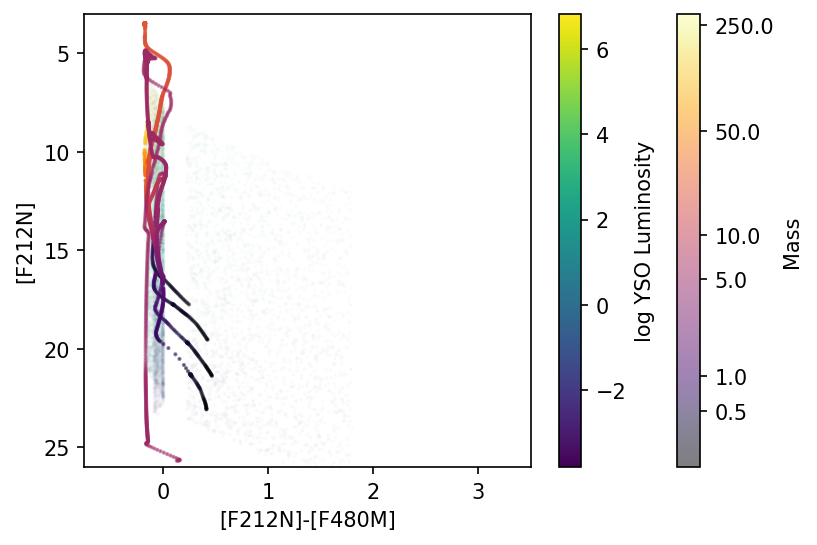

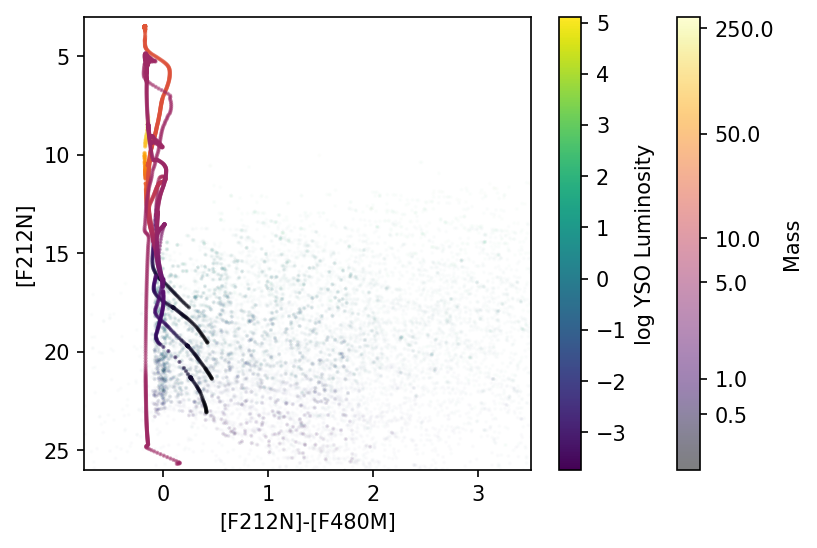

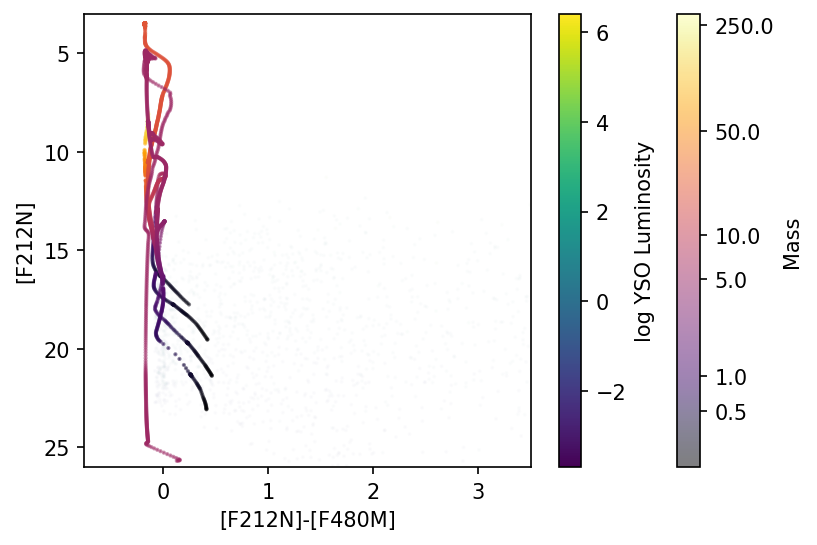

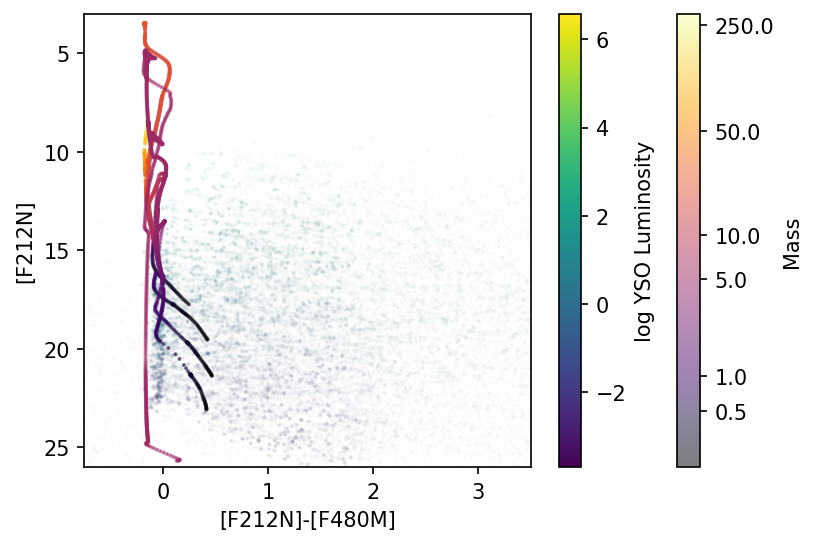

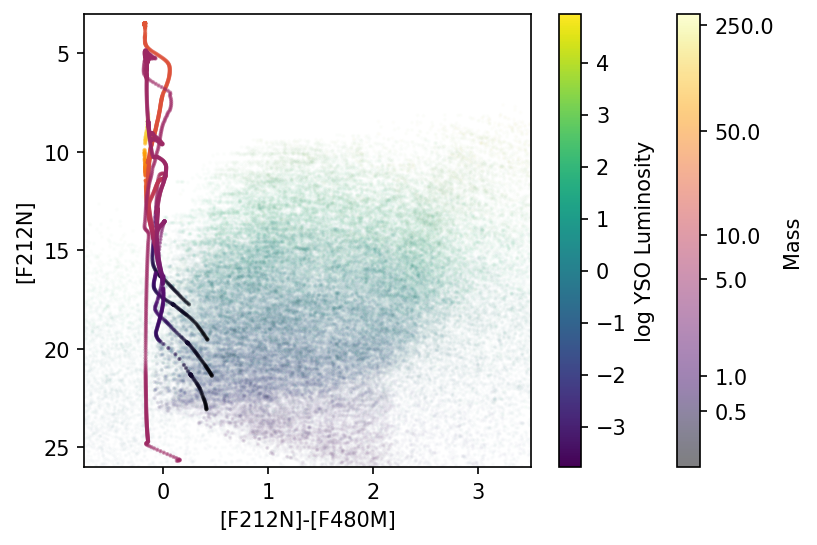

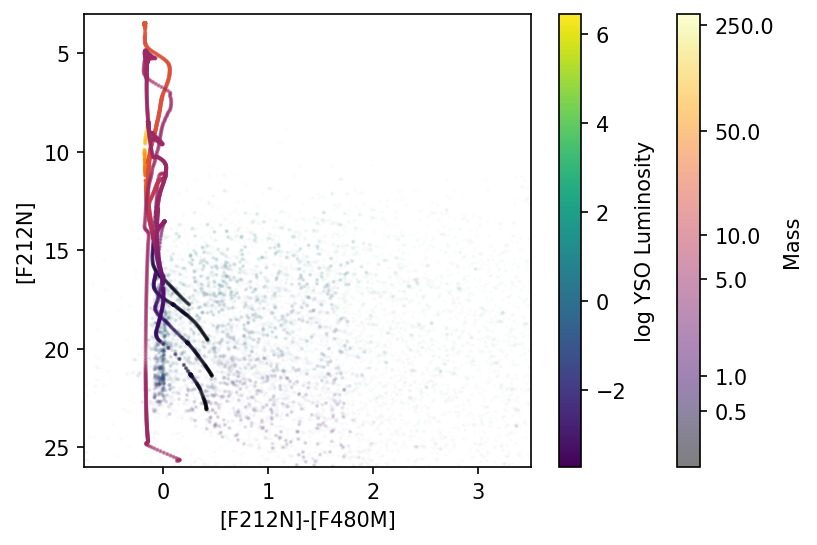

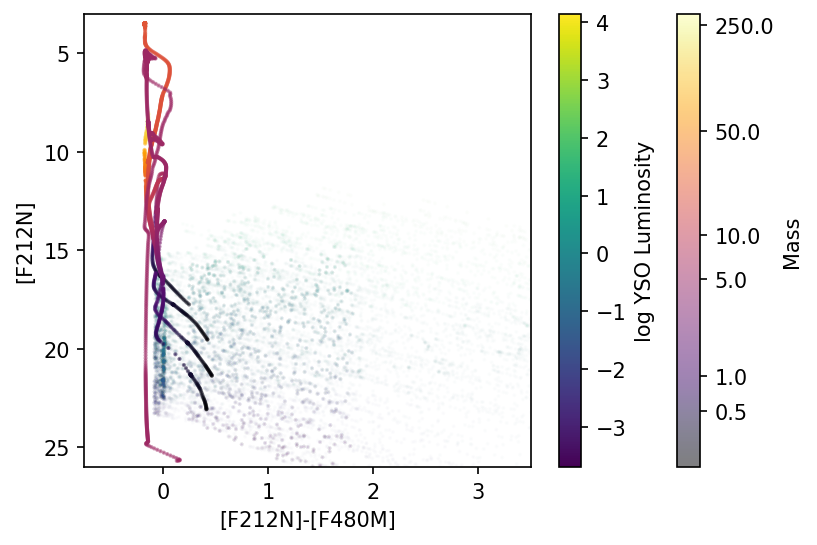

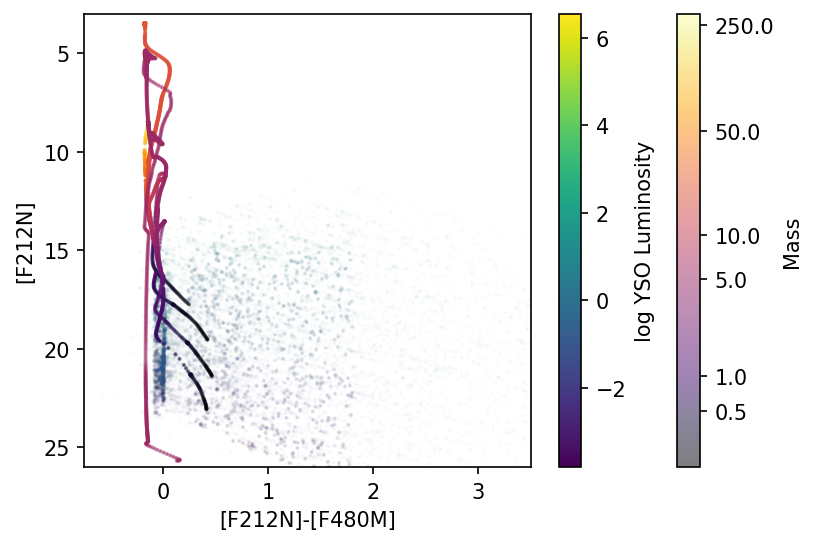

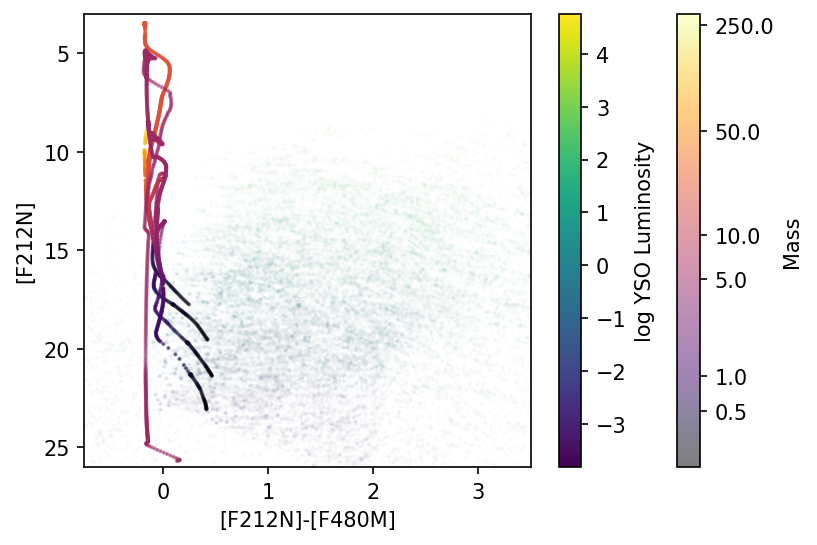

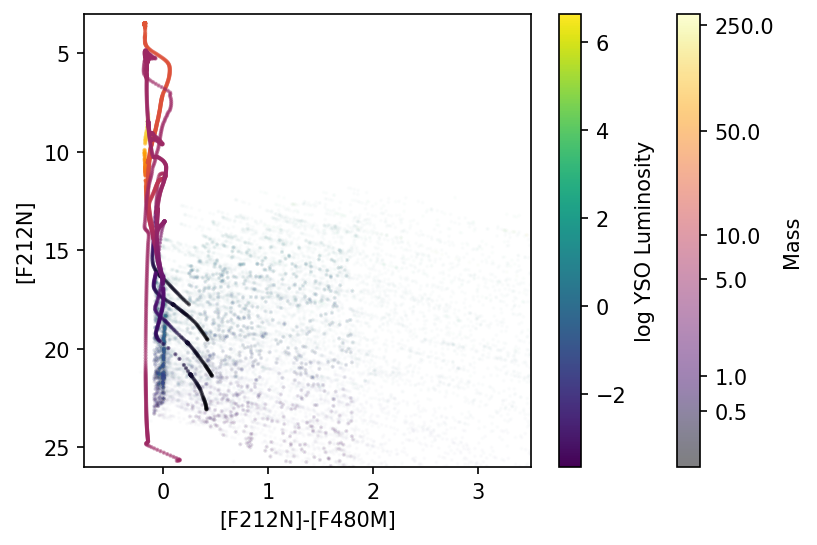

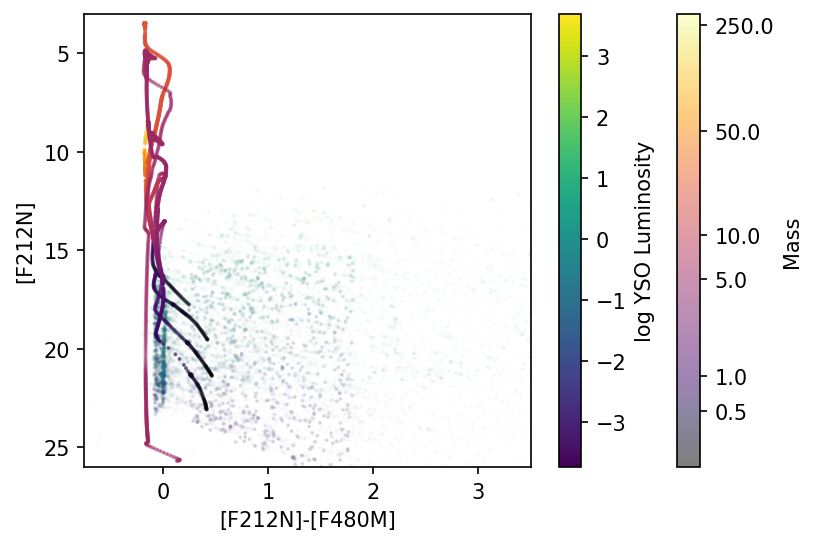

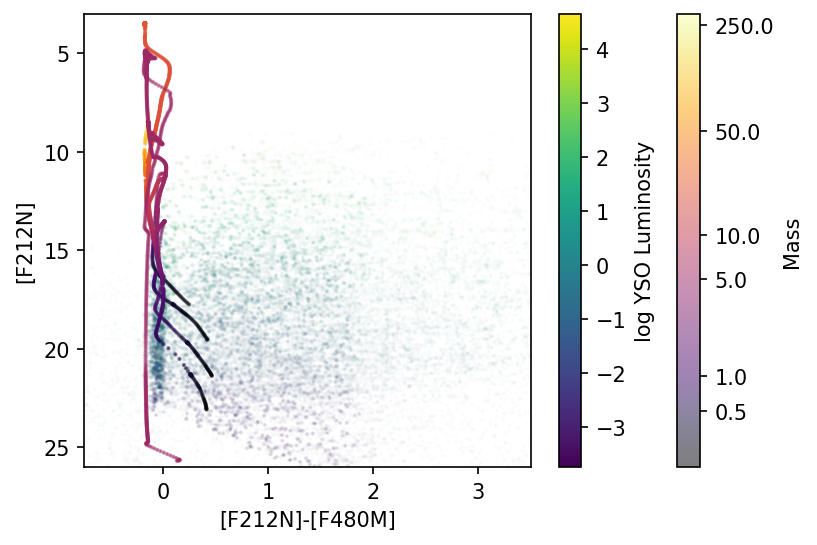

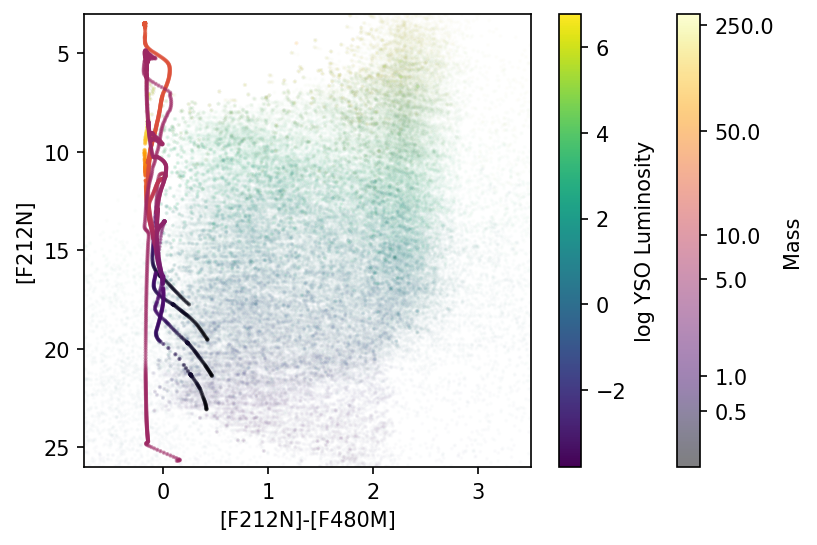

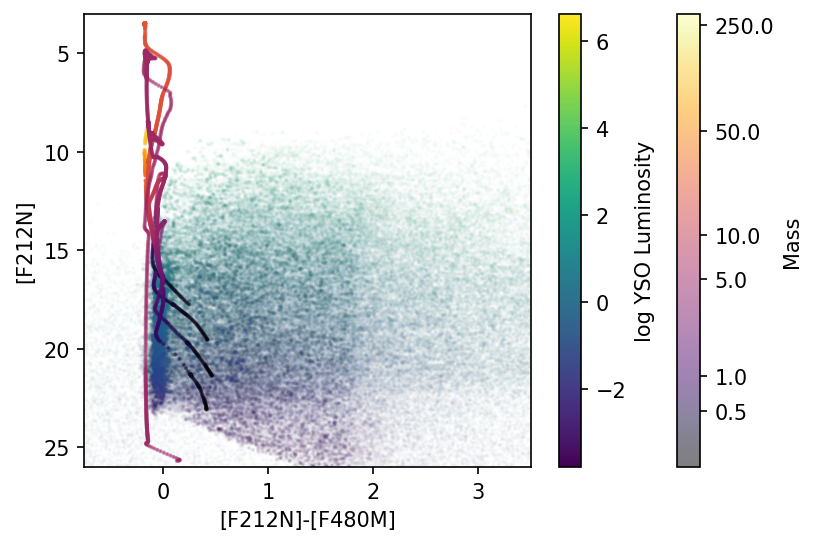

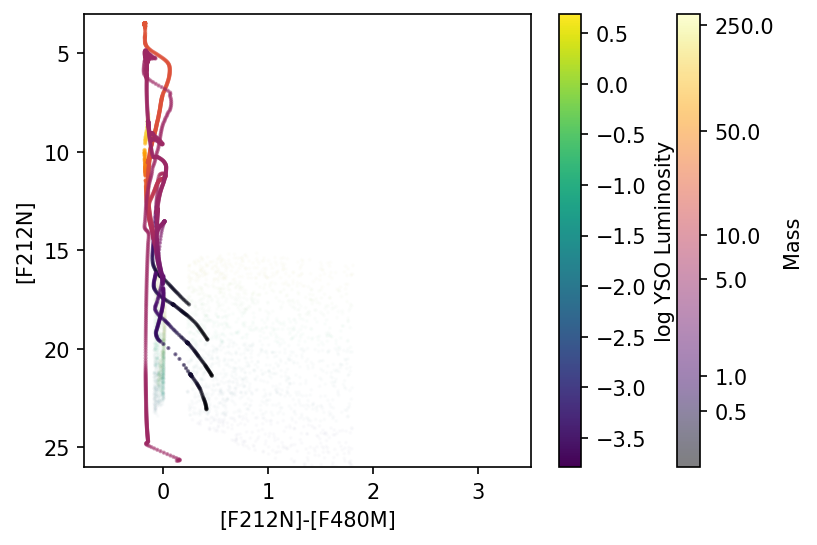

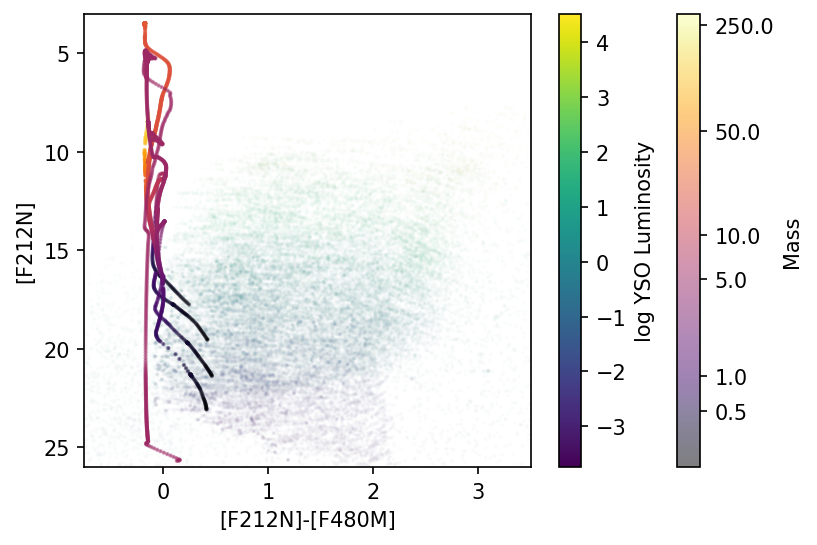

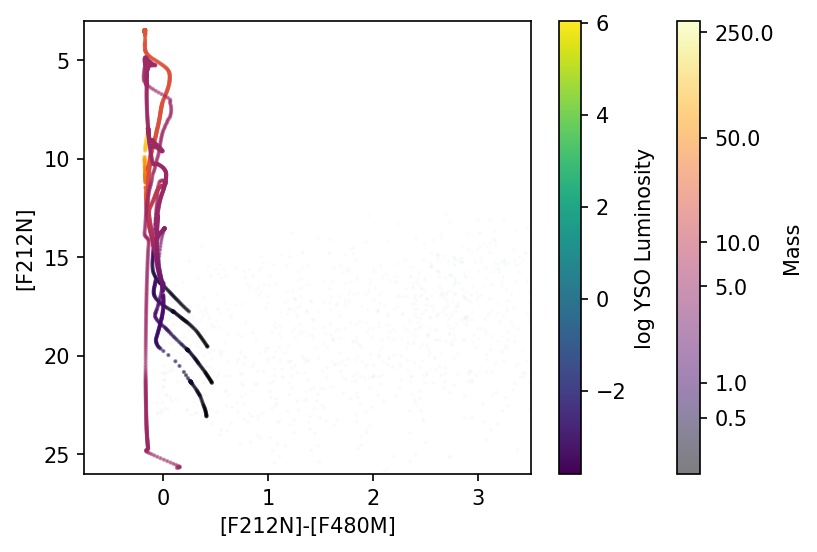

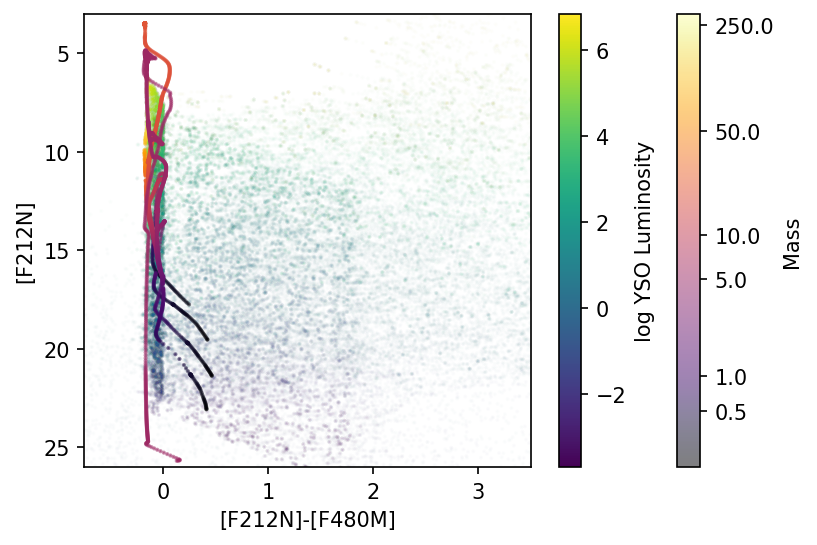

In [80]:
for geom in augpars_dict:
    pl.figure(dpi=150)

    norm = simple_norm(mist['initial_mass'][mist['log10_isochrone_age_yr'] < 7], stretch='log')
    for age in np.unique(mist['log10_isochrone_age_yr']):
        if age in (5,6,7,8):

            agesel = mist['log10_isochrone_age_yr'] == age
            pl.scatter(mist['F212N'][agesel] - mist['F480M'][agesel],
                       (mist['F212N'])[agesel]+distance_modulus,
                       c=mist['initial_mass'][agesel],
                       norm=norm,
                       cmap='inferno',
                       alpha=0.5,
                       s=1,
                      )


    cb = pl.colorbar()
    cb.set_ticks([0.5,1,5,10,50,250])
    cb.set_label("Mass")

    #mag212 = (u.Quantity(f212s['s---s-i']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2).to(u.ABmag)
    #mag480 = (u.Quantity(f480s['s---s-i']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2).to(u.ABmag)
    mag212 = -2.5*np.log10((u.Quantity(f212s[geom]['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2) / u.Quantity(jfilts.loc['JWST/NIRCam.F212N']['ZeroPoint'], u.Jy))
    mag480 = -2.5*np.log10((u.Quantity(f480s[geom]['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2) / u.Quantity(jfilts.loc['JWST/NIRCam.F480M']['ZeroPoint'], u.Jy))
    pl.scatter(mag212-mag480, mag212, s=1,
               c=np.log10(augpars_dict[geom]['Model Luminosity']),
               alpha=0.01, zorder=-10)
    #pl.title(geom)
    cb2 = pl.colorbar()
    cb2.set_label("log YSO Luminosity")
    cb2.set_alpha(1)
    cb2.draw_all()

    #pl.axhline(0, linestyle='--', color='k')
    #pl.axvline(0, linestyle='--', color='k')
    pl.xlabel("[F212N]-[F480M]")
    pl.ylabel("[F212N]")
    #pl.axis([-0.2,0.1,-0.1,0.3])
    pl.ylim(26,3)
    pl.xlim([-0.75, 3.5]);
    #agesel.sum()
    pl.savefig(f"JWST_F212NF480M_CMD_{geom}.png", bbox_inches='tight')

In [81]:
mist['log_L'].max()

6.81723673721364

/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/function/logarithmic.py:67: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))


(-5.0, 5.0, 20.0, 0.0)

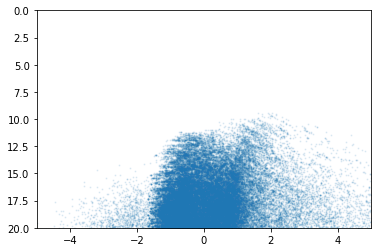

In [82]:
mag212 = (u.Quantity(f212s['spubsmi']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2).to(u.ABmag)
mag480 = (u.Quantity(f480s['spubsmi']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2).to(u.ABmag)
pl.scatter(mag212-mag480, mag212, s=1, alpha=0.1)
pl.axis([-5,5,20,0])

(-5.0, 5.0, 20.0, 0.0)

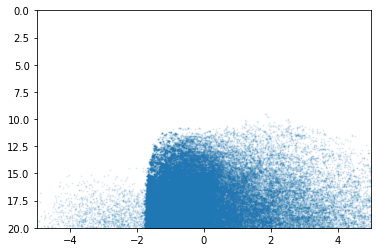

In [83]:
mag212 = (u.Quantity(f212s['spubhmi']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2).to(u.ABmag)
mag480 = (u.Quantity(f480s['spubhmi']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2).to(u.ABmag)
pl.scatter(mag212-mag480, mag212, s=1, alpha=0.1)
pl.axis([-5,5,20,0])

In [84]:
5 * np.log10(8.5)

4.647094628571463

In [85]:
(f212s['s---s-i']['TOTAL_FLUX'].quantity).to(u.ABmag)[:,5].min().value + 5 * np.log10(8.5)

7.897685711908455

In [86]:
(f212s['s---s-i']['TOTAL_FLUX'].quantity).to(u.ABmag)[:,5].min().value - 5

-1.7494089166630085

In [87]:
(-2.5*np.log10(f212s['s---s-i']['TOTAL_FLUX'].quantity/(666*u.Jy))).min() - 5

<Quantity -3.59072334>

In [88]:
augpars_dict['s---s-i']

<Table length=10000>
 MODEL_NAME star.radius star.temperature scattering inclination    Model Luminosity  
                                                                        solLum       
  bytes20     float64       float64        int64      float64          float64       
----------- ----------- ---------------- ---------- ----------- ---------------------
01QyhoBc_01      0.2728           4888.0          1        45.0   0.03827429493798022
01Xx6elC_01       0.383          12050.0          1        45.0    2.7863740310410456
03ZZRVTe_01       31.22           4967.0          1        45.0     534.4857312835463
03amqKIp_01       13.81           7891.0          1        45.0     666.2070265981496
03dloFhH_01       44.63           6450.0          1        45.0    3105.8917167595805
03jGXYVQ_01       4.797           9889.0          1        45.0     198.2634334117127
05DVDxNM_01      0.6069           4998.0          1        45.0   0.20706798645839214
05qQySTl_01       8.242           7737.0          1        45.0    219.30538007941993
05tRaRtL_01       50.31           6017.0          1        45.0    2988.9755251569054
06Xo35xd_01       4.711          28510.0          1        45.0    13210.180629544346
07MlMhxq_01      0.1296           5922.0          1        45.0  0.018611325021550378
07RUrGEE_01      0.1938          23260.0          1        45.0      9.90467125005583
07hfvkVw_01        1.79           4230.0          1        45.0    0.9241898823484598
080tzfe2_01       26.38           5936.0          1        45.0      778.428682352435
08EDk50n_01       98.54           3544.0          1        45.0      1380.04626808806
08HoNhQn_01       94.44           4798.0          1        45.0      4258.40153401381
08SOZzlX_01      0.9985           5055.0          1        45.0    0.5865086969868257
09OZKYKD_01       11.74          27190.0          1        45.0     67868.25804825939
0A5GdtmT_01       1.808          10550.0          1        45.0     36.48382543530038
0AtR95Jq_01      0.1007           5885.0          1        45.0  0.010958181468019844
0AyBNm0W_01      0.1804           8051.0          1        45.0   0.12318733254144446
0aM9lyOR_01       0.727          20330.0          1        45.0     81.34146959696413
0abOBlIT_01       10.46          14920.0          1        45.0    4884.6375068103835
0ahVt3Db_01       40.56          10390.0          1        45.0     17272.36317874308
0avUBjK3_01       3.112           2048.0          1        45.0   0.15349444543936583
0B4wuXlN_01       5.091           7656.0          1        45.0      80.2246020395295
0BeXGFlb_01       17.61          11430.0          1        45.0     4768.670463619687
0Bgb9g9q_01       72.23          16380.0          1        45.0     338364.2706016679
0BjUtCiu_01       16.31           3341.0          1        45.0     29.86121695833552
0b2YeOUX_01       34.99           9225.0          1        45.0     7988.165656191767
0Cm9HQ43_01       7.864           4279.0          1        45.0    18.678837068231147
0CxrYnof_01      0.2098           4733.0          1        45.0  0.019899889453708346
        ...         ...              ...        ...         ...                   ...
zwANamOd_01       22.29          16440.0          1        45.0     32697.99085628733
zwJIyvkr_01       6.481           3058.0          1        45.0     3.309235278149707
zwnPmJZT_01       10.22          29340.0          1        45.0      69732.6079634379
zwndXBFi_01       78.84           8260.0          1        45.0    26067.963172057545
Zxks2f7T_01       73.84          29380.0          1        45.0     3660026.417905267
zX4RjfqK_01       3.822           9787.0          1        45.0    120.74617915183987
zXC0i0Xw_01       1.638          11510.0          1        45.0     42.42508954496866
zXDLE4ba_01      0.1069           4280.0          1        45.0 0.0034548099740806413
zXKc6UnC_01      0.4373           8234.0          1        45.0    0.7919469373169471
zXtnULYU_01       87.98

In [89]:
augpars_dict['s---s-i']['star.temperature']

<Column name='star.temperature' dtype='float64' length=10000>
 4888.0
12050.0
 4967.0
 7891.0
 6450.0
 9889.0
 4998.0
 7737.0
 6017.0
28510.0
 5922.0
23260.0
 4230.0
 5936.0
 3544.0
 4798.0
 5055.0
27190.0
10550.0
 5885.0
 8051.0
20330.0
14920.0
10390.0
 2048.0
 7656.0
11430.0
16380.0
 3341.0
 9225.0
 4279.0
 4733.0
 2196.0
18110.0
24870.0
    ...
 6165.0
12020.0
16440.0
 3058.0
29340.0
 8260.0
29380.0
 9787.0
11510.0
 4280.0
 8234.0
13000.0
 3508.0
 2591.0
19470.0
 2551.0
 2181.0
 6443.0
27900.0
 4633.0
 2302.0
14450.0
 2722.0
 5199.0
 6823.0
 5046.0
 3576.0
 6997.0
 2070.0
21470.0
18890.0
 2151.0
10820.0
 7466.0
 9033.0

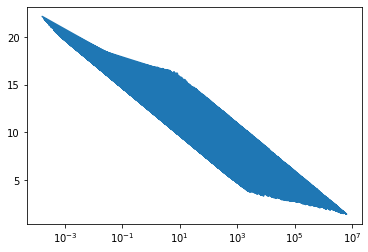

In [90]:
pl.semilogx(augpars_dict['s---s-i']['Model Luminosity'], (-2.5*np.log10(f212s['s---s-i']['TOTAL_FLUX'][:,5].quantity/(666*u.Jy))),
           )
           #c=np.array(augpars_dict['s---s-i']['star.temperature'], dtype='float'))


(-5.0, 5.0, 20.0, 0.0)

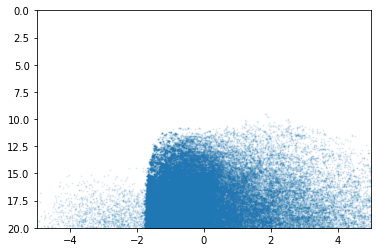

In [91]:
mag212 = (u.Quantity(f212s['spubhmi']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2).to(u.ABmag)
mag480 = (u.Quantity(f480s['spubhmi']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2).to(u.ABmag)
pl.scatter(mag212-mag480, mag212, s=1, alpha=0.1)
pl.axis([-5,5,20,0])

(-5.0, 5.0, 20.0, 0.0)

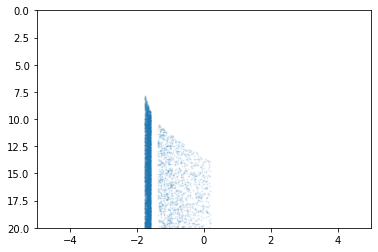

In [92]:
mag212 = (u.Quantity(f212s['s---s-i']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2).to(u.ABmag)
mag480 = (u.Quantity(f480s['s---s-i']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2).to(u.ABmag)
pl.scatter(mag212-mag480, mag212, s=1, alpha=0.1)
pl.axis([-5,5,20,0])

In [93]:
augpars_dict['spubsmi']

<Table length=360000>
 MODEL_NAME star.radius star.temperature disk.mass disk.rmax disk.beta  disk.p disk.h100 ...    Model Luminosity                 Line-of-Sight Masses                     Sphere Masses            Outer Radius    Line-of-Sight Weighted Temperatures Sphere Weighted Temperatures    Disk Minimum Q  
                                                                                         ...         solLum                                                                                                                                                                                            
  bytes20     float64       float64       float64   float64   float64  float64  float64  ...        float64                          float64[20]                           float64[20]               float64                   float64[20]                     float64[20]                float64      
----------- ----------- ---------------- --------- --------- --------- ------- --------- ... --------------------- ----------------------------------------------- ---------------------------- ------------------ ----------------------------------- ---------------------------- -------------------
003NEvmw_01      0.2219          19040.0   0.05491    1874.0     1.276  -1.931     4.612 ...     5.830100737379585        3.3430566353829443 .. 2750.8216889355535     3.3720396198182043 .. --  605996.0389155973             100.5280662025255 .. --     100.54304871575859 .. -- 0.03007397857692694
003NEvmw_02      0.2219          19040.0   0.05491    1874.0     1.276  -1.931     4.612 ...     5.830100737379585         3.344021440770447 .. 2750.8216889354862     3.3720396198182043 .. --  605996.0389155973            100.50826128338862 .. --     100.54304871575859 .. -- 0.03007397857692694
003NEvmw_03      0.2219          19040.0   0.05491    1874.0     1.276  -1.931     4.612 ...     5.830100737379585          3.370949393857458 .. 2750.821688935478     3.3720396198182043 .. --  605996.0389155973             99.90316961348775 .. --     100.54304871575859 .. -- 0.03007397857692694
003NEvmw_04      0.2219          19040.0   0.05491    1874.0     1.276  -1.931     4.612 ...     5.830100737379585         3.422554948849835 .. 2750.8216889354458     3.3720396198182043 .. --  605996.0389155973              98.7689346670353 .. --     100.54304871575859 .. -- 0.03007397857692694
003NEvmw_05      0.2219          19040.0   0.05491    1874.0     1.276  -1.931     4.612 ...     5.830100737379585        3.4739684083219635 .. 2750.8216889354726     3.3720396198182043 .. --  605996.0389155973             97.66068075708188 .. --     100.54304871575859 .. -- 0.03007397857692694
003NEvmw_06      0.2219          19040.0   0.05491    1874.0     1.276  -1.931     4.612 ...     5.830100737379585        3.4911778499881145 .. 2750.8216889354817     3.3720396198182043 .. --  605996.0389155973             97.29461229841284 .. --     100.54304871575859 .. -- 0.03007397857692694
003NEvmw_07      0.2219          19040.0   0.05491    1874.0     1.276  -1.931     4.612 ...     5.830100737379585         3.6025251335837525 .. 2750.821688935421     3.3720396198182043 .. --  605996.0389155973             94.98326579639196 .. --     100.54304871575859 .. -- 0.03007397857692694
003NEvmw_08      0.2219          19040.0   0.05491    1874.0     1.276  -1.931     4.612 ...     5.830100737379585        3.6927126477313568 .. 2750.8216889354126     3.3720396198182043 .. --  605996.0389155973             93.16904077335124 .. --     100.54304871575859 .. -- 0.03007397857692694
003NEvmw_09      0.2219          19040.0   0.05491    1874.0     1.276  -1.931     4.612 ...     5.830100737379585         3.792810649646759 .. 2750.8216889354426     3.3720396198182043 .. --  605996.0389155973             91.18688536046432 .. --     100.54304871575859 .. -- 0.03007397857692694
008XqlRT_01      0.1268          16970.0 5.114e-08     105.6      1.27 -0.8163      16.4 ...     1.201322343507964  4.928564553012

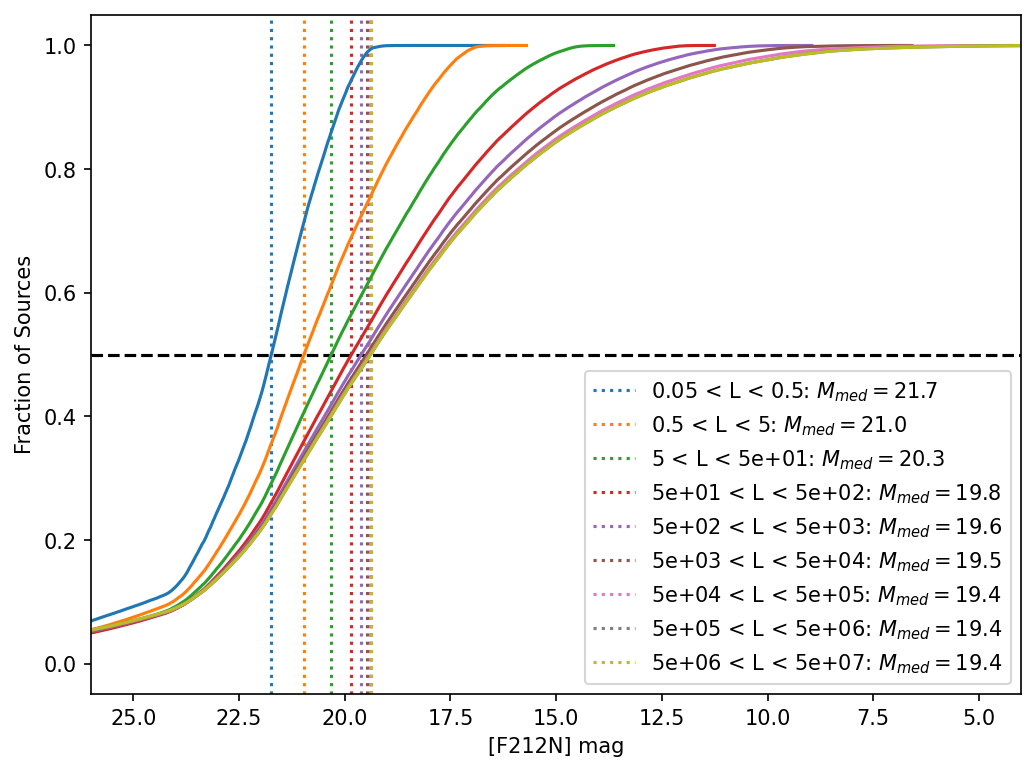

In [94]:
pl.figure(figsize=(8,6), dpi=150)
data = []
for lumlo, lumhi in ([(0.05, 0.5), (0.5, 5), (5, 50), (50, 500), (500, 5000), (5e3, 5e4), (5e4, 5e5), (5e5, 5e6), (5e6, 5e7)]):
    for geom in geoms:
        pars = augpars_dict[geom]
        f212 = f212s[geom]
        lum = pars['Model Luminosity']
        lumsel = (lum > lumlo) & (lum <= lumhi)
        if any(lumsel):
            #pl.hist(f212['TOTAL_FLUX'][lumsel, 5], bins=np.geomspace(0.01, 10), label=geom)
            rslt = f212['TOTAL_FLUX'][lumsel, 5]
            rslt = rslt[np.isfinite(rslt)]
            rslt = np.sort(rslt)
            data = np.hstack([data, rslt])
            #pl.plot(rslt / (8.5**2), np.arange(len(rslt)) / len(rslt), label=geom)
    data = np.sort(data)
    magdata = (u.Quantity(data, u.mJy) / (8.5**2)).to(u.ABmag)
    L, = pl.plot(magdata.value, np.arange(len(data)) / len(data))
    #print(np.median(magdata))
    medmag = np.median(magdata).value
    #print(medmag)
    pl.axvline(medmag, linestyle=':', zorder=-100, color=L.get_color(), label=f'{lumlo:0.1g} < L < {lumhi:0.1g}: $M_{{med}}={medmag:0.1f}$')
    #pl.axvline(22.5, linestyle='--', color='k', zorder=-50)
pl.legend(loc='best')# bbox_to_anchor=(1.1,1))
pl.axhline(0.5, linestyle='--', color='k', zorder=-50)
pl.xlabel("[F212N] mag")
pl.ylabel("Fraction of Sources")
pl.xlim(26, 4);

In [95]:

fig = pl.figure(figsize=(10, 10), dpi=150)

combos = [(colors_N[ii-1], colors_N[jj-1]) for ii,jj in ((2,3), (2,4), (1,5), (2,3),) ]
gridspec = sqgrid.get_grid(len(combos));

xarr = np.linspace(1, 5, 10000)*u.um
rawspec = np.ones(xarr.size, dtype=float)*u.Jy
av = 30


for ii, (color1, color2) in enumerate(combos):
    ax = fig.add_subplot(gridspec[ii])
    for geom, cmap in zip(('spubsmi', 'sp--smi',), ('viridis', 'inferno')):
        Lgt1 = augpars_dict[geom]['Model Luminosity'] > 1
        tbs = {cname: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/{geom}/convolved/JWST/{cname}.fits')
               for cname in color1 + color2}
        keys1 = [col for col in color1]
        keys2 = [col for col in color2]
        colorp1 = -2.5*np.log10(tbs[keys1[0]]['TOTAL_FLUX'][:, 5]) + 2.5*np.log10(tbs[keys1[1]]['TOTAL_FLUX'][:, 5])
        colorp2 = -2.5*np.log10(tbs[keys2[0]]['TOTAL_FLUX'][:, 5]) + 2.5*np.log10(tbs[keys2[1]]['TOTAL_FLUX'][:, 5])
        sc = ax.scatter(colorp1[Lgt1], colorp2[Lgt1], s=2, alpha=0.1,
                        c=np.log10(augpars_dict[geom]['Model Luminosity'])[Lgt1],
                        norm=simple_norm(np.log10(augpars_dict[geom]['Model Luminosity'])[Lgt1], stretch='linear',
                                      min_cut=0, max_cut=5),
                        cmap=cmap
                       )#(np.log10(augpars['Model Luminosity'])))
    #ax.scatter(colorp1[sel], colorp2[sel], s=5, alpha=0.5, c='r')
    ax.set_xlabel(f"{color1[0]} - {color1[1]}")
    ax.set_ylabel(f"{color2[0]} - {color2[1]}")
    ax.axis((-2,5,-2,5))
    cb = pl.colorbar(mappable=sc, ax=ax)
    cb.set_label('log Luminosity')
    wl1_um = int(color1[0][-4:-1])*u.um/100
    wl2_um = int(color1[1][-4:-1])*u.um/100
    wl3_um = int(color2[0][-4:-1])*u.um/100
    wl4_um = int(color2[1][-4:-1])*u.um/100
    extcol1 = av * (ext(wl1_um) - ext(wl2_um))
    extcol2 = av * (ext(wl3_um) - ext(wl4_um))

    for molecule, column, ccc in zip(('co', 'h2o', 'co2'),
                                      # normalized to a_v=30 in fig7 of boogert / Tb 2 of boogert
                             (1e-5 * av * 1e21, 4e-5 * av * 1e21, 1.3e-5*av*1e21),
                             ('orange', 'purple', 'red')):
        moldata = molecule_data[molecule]
        consts = load_molecule(molecule)
        spec = absorbed_spectrum(column*u.cm**-2, consts,
                                 molecular_weight=moldata['molwt'],
                                 spectrum=rawspec,
                                 xarr=xarr,
                                )
        flxd = fluxes_in_filters(xarr, spec)
        flxd_raw = fluxes_in_filters(xarr, rawspec)
        icecolor1 = flxd['JWST/'+color1[0]].to(u.ABmag).value - flxd['JWST/'+color1[1]].to(u.ABmag).value
        icecolor2 = flxd['JWST/'+color2[0]].to(u.ABmag).value - flxd['JWST/'+color2[1]].to(u.ABmag).value

        arrow_start = (0, 0)
        arrow_end = (0 + icecolor1, 0 + icecolor2)
        print(arrow_start, arrow_end)
        ax.annotate('', arrow_end, arrow_start,
            arrowprops=dict(width=1, headwidth=5, headlength=5,
            edgecolor=ccc,
            facecolor=ccc, ),
            color=ccc,
           )

    arrow_start = (0, 0)
    arrow_end = (0 + extcol1, 0 + extcol2)
    print(arrow_start, arrow_end)
    ax.annotate('', arrow_end, arrow_start,
        arrowprops=dict(width=1, headwidth=5, headlength=5,
        edgecolor='k',
        facecolor='k', ),
        color='k',
       )    
    
fig.suptitle('spubsmi for L$>1$ L$_\\odot$');

NameError: name 'colors_N' is not defined

<Figure size 1500x1500 with 0 Axes>